In [2]:
import numpy as np
import scipy.sparse as sp
np.random.seed(12)

import warnings
#Comment this to turn on warnings
warnings.filterwarnings('ignore')

### define Ising model aprams
# system size
L=40

# create 10000 random Ising states
states=np.random.choice([-1, 1], size=(10000,L))

def ising_energies(states,L):
    """
    This function calculates the energies of the states in the nn Ising Hamiltonian
    """
    J=np.zeros((L,L),)
    for i in range(L):
        J[i,(i+1)%L]-=1.0
    # compute energies
    E = np.einsum('...i,ij,...j->...',states,J,states)
    return E
# calculate Ising energies
energies=ising_energies(states,L)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import scipy.linalg as scl
from sklearn.model_selection import train_test_split
import sklearn.linear_model as skl
#from tqdm import tqdm
sns.set(color_codes=True)
cmap_args=dict(vmin=-1., vmax=1., cmap='seismic')

L = 40
n = int(1e4)

spins = np.random.choice([-1, 1], size=(n, L))
J = 1.0

energies = np.zeros(n)

for i in range(n):
    energies[i] = - J * np.dot(spins[i], np.roll(spins[i], 1))
    
energies

array([-8., -4., -0., ..., -4.,  4., -0.])

In [5]:
X = np.zeros((n, L ** 2))
for i in range(n):
    X[i] = np.outer(spins[i], spins[i]).ravel()
y = energies
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.96)

X_train_own = np.concatenate(
    (np.ones(len(X_train))[:, np.newaxis], X_train),
    axis=1
)

X_test_own = np.concatenate(
    (np.ones(len(X_test))[:, np.newaxis], X_test),
    axis=1
)

In [6]:
def get_ols_weights(x: np.ndarray, y: np.ndarray) -> np.ndarray:
    u, s, v = scl.svd(x)
    return v.T @ scl.pinv(scl.diagsvd(s, u.shape[0], v.shape[0])) @ u.T @ y

def get_ols_weights(x: np.ndarray, y: np.ndarray) -> np.ndarray:
    u, s, v = scl.svd(x)
    return v.T @ scl.pinv(scl.diagsvd(s, u.shape[0], v.shape[0])) @ u.T @ y

In [7]:
# function for calculation of regression coefficients in Project 1
# this is not applicaple in this project, as it uses matrix inversion
# and is specific for the polynomial approximations used in Proj 1
#def betareg(x,y,z,degree):             
    #input1 : x-vector
    #input2 : y-vector
    #input3 : given observed data z
    #input4 : degree of polynomial for fit
    #output : coefficients for polynomial fit
   
    #X = designmatrix(x,y,degree)
    
    # Calculation of beta
    #XtX = np.transpose(X).dot(X)
    #XtXinvers = np.linalg.inv(XtX)
    #betareg = (XtXinvers.dot(np.transpose(X))).dot(z)   #our coefficients for the Regression

    #return betareg 

In [8]:
def betareg(X,y):             
    #input1 : x-vector
    #input3 : given observed data z
    #output : coefficients for OLS regression
    
    # Calculation of coefficients
    u, s, v = scl.svd(X)
    betareg = v.T @ scl.pinv(scl.diagsvd(s, u.shape[0], v.shape[0])) @ u.T @ y

    return betareg 

In [9]:
omega = get_ols_weights(X_train_own,y_train)

In [12]:
#sklearn comparison
clf = skl.LinearRegression().fit(X_train, y_train)
J_own = omega[1:].reshape(L, L)
J_sk = clf.coef_.reshape(L, L)

In [13]:
print(J_own-J_sk)

[[-5.46376232e-02  7.82534345e-02  6.98266014e-02 ... -7.43649658e-03
  -8.84806499e-03  1.85412382e-02]
 [-1.15101845e-03 -1.40293749e-02  4.19589940e-02 ... -1.53981680e-02
  -1.87759897e-02 -3.96741979e-03]
 [-4.81587970e-02 -7.63517670e-03  2.84177415e-02 ... -7.99238912e-03
  -1.93112790e-02 -3.06096870e-02]
 ...
 [ 9.18703487e-03  9.33355175e-03 -3.32852726e-03 ...  4.15305423e-04
   1.83374319e-02  6.00616363e-03]
 [-6.64675765e-03  1.03429251e-02  5.76416930e-05 ...  1.83374319e-02
   4.15305423e-04  8.84603807e-04]
 [ 7.96442716e-03 -1.04757341e-02 -6.64267182e-03 ...  6.00616363e-03
   8.84603807e-04  4.15305423e-04]]


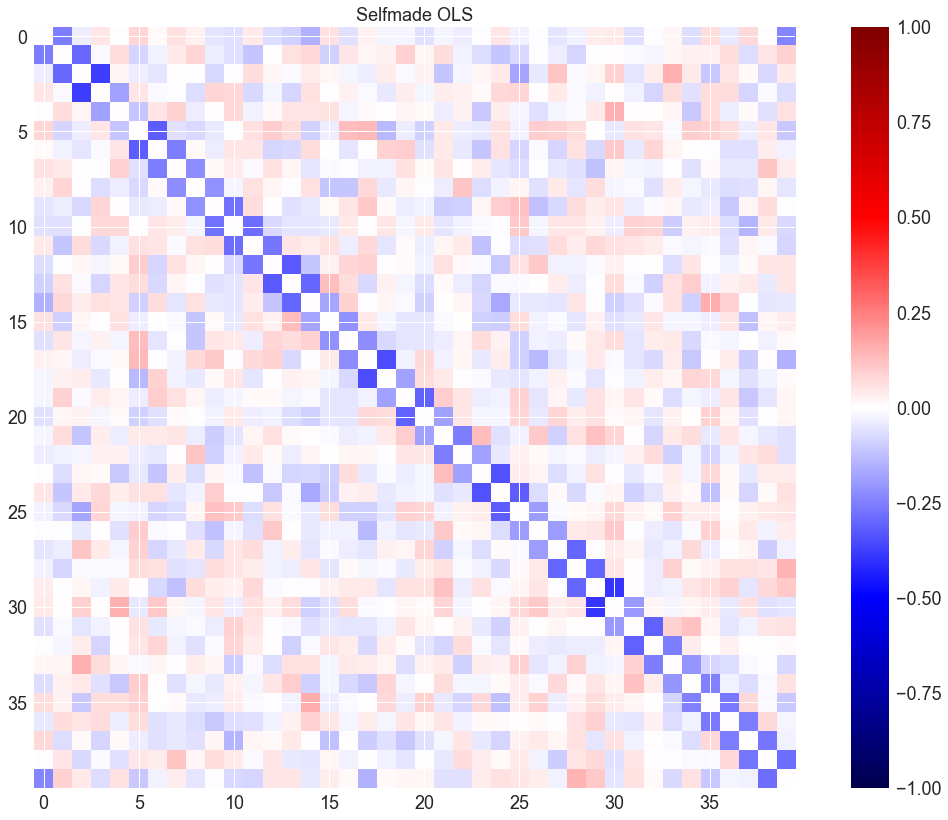

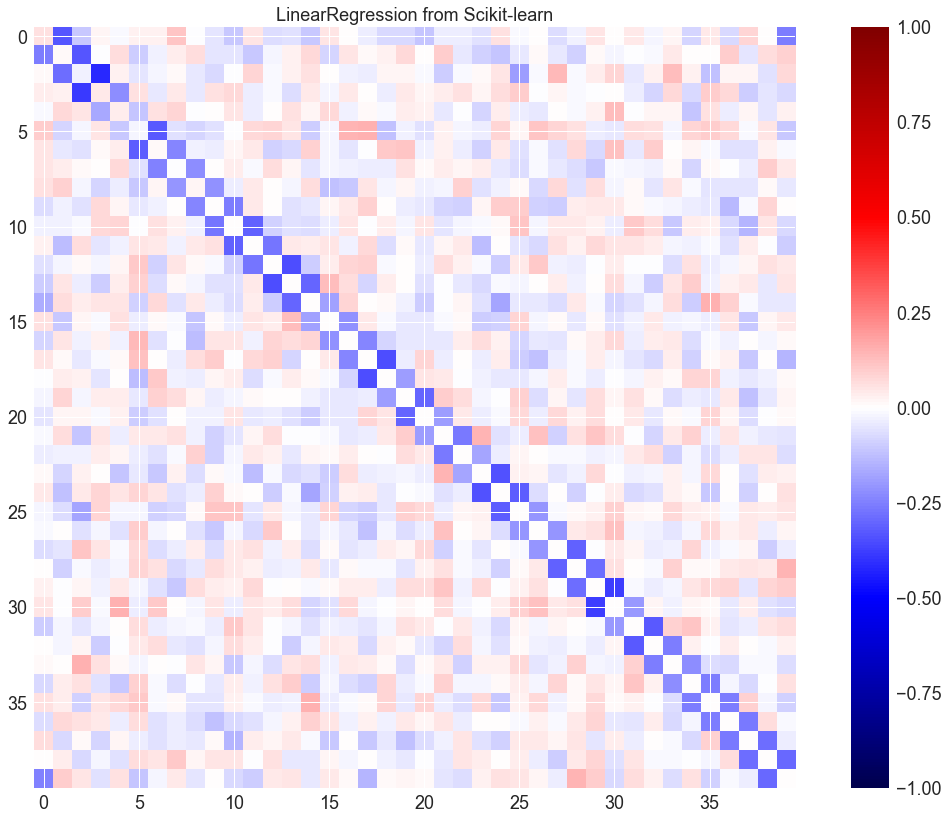

In [14]:
fig = plt.figure(figsize=(20, 14))
im = plt.imshow(J_own, **cmap_args)
plt.title("Selfmade OLS", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
cb = fig.colorbar(im)
cb.ax.set_yticklabels(cb.ax.get_yticklabels(), fontsize=18)

fig = plt.figure(figsize=(20, 14))
im = plt.imshow(J_sk, **cmap_args)
plt.title("LinearRegression from Scikit-learn", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
cb = fig.colorbar(im)
cb.ax.set_yticklabels(cb.ax.get_yticklabels(), fontsize=18)
plt.show()

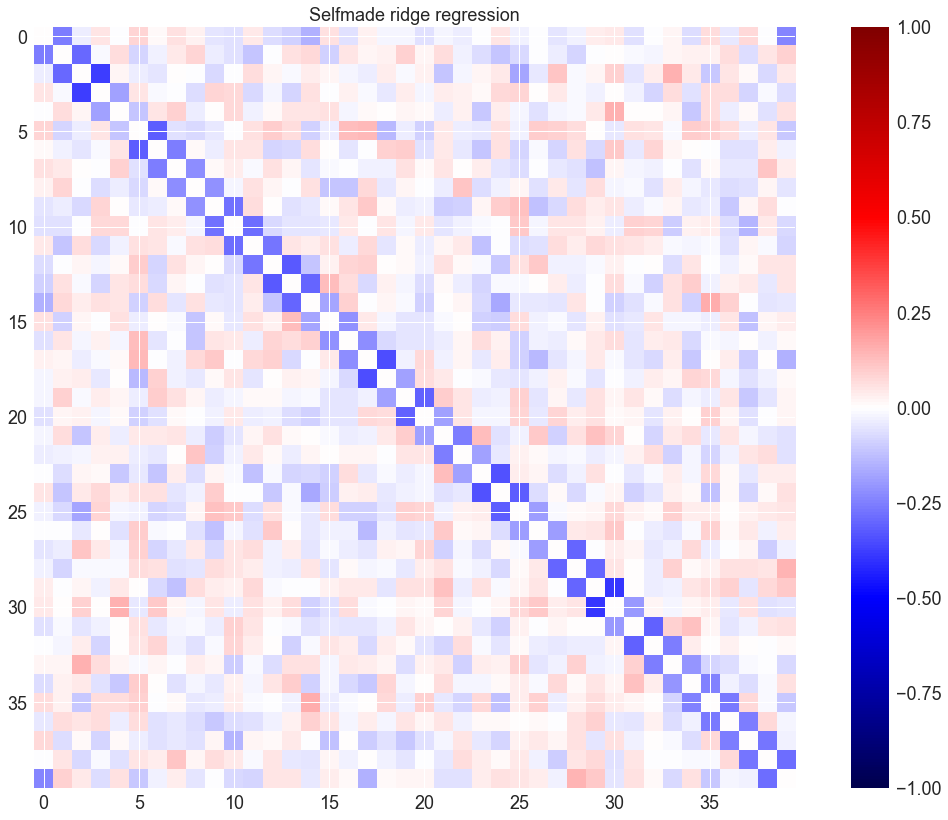

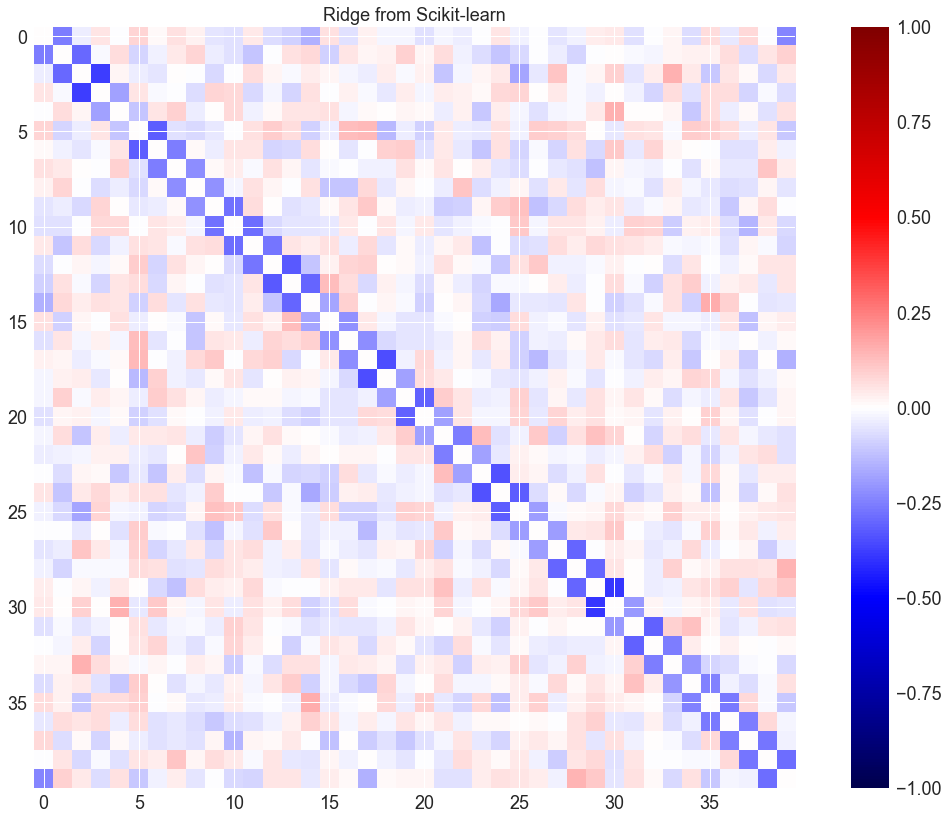

In [15]:
def get_ridge_weights(x: np.ndarray, y: np.ndarray, _lambda: float) -> np.ndarray:
    return x.T @ y @ scl.inv(
        x.T @ x + np.eye(x.shape[1], x.shape[1]) * _lambda
    )
_lambda = 0.01
omega_ridge = get_ridge_weights(X_train_own, y_train, np.array([_lambda]))
clf_ridge = skl.Ridge(alpha=_lambda).fit(X_train, y_train)
J_ridge_own = omega_ridge[1:].reshape(L, L)
J_ridge_sk = clf_ridge.coef_.reshape(L, L)
fig = plt.figure(figsize=(20, 14))
im = plt.imshow(J_ridge_own, **cmap_args)
plt.title("Selfmade ridge regression", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
cb = fig.colorbar(im)
cb.ax.set_yticklabels(cb.ax.get_yticklabels(), fontsize=18)

fig = plt.figure(figsize=(20, 14))
im = plt.imshow(J_ridge_sk, **cmap_args)
plt.title("Ridge from Scikit-learn", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
cb = fig.colorbar(im)
cb.ax.set_yticklabels(cb.ax.get_yticklabels(), fontsize=18)

plt.show()

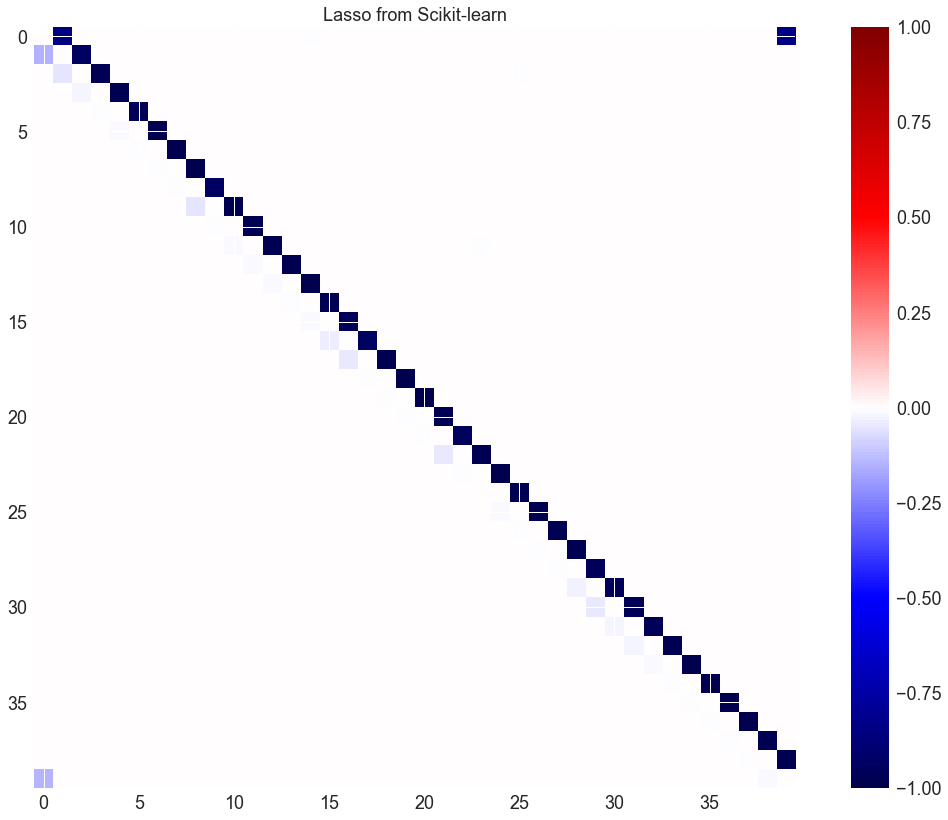

In [16]:
clf_lasso = skl.Lasso(alpha=_lambda).fit(X_train, y_train)
J_lasso_sk = clf_lasso.coef_.reshape(L, L)
fig = plt.figure(figsize=(20, 14))
im = plt.imshow(J_lasso_sk, **cmap_args)
plt.title("Lasso from Scikit-learn", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
cb = fig.colorbar(im)
cb.ax.set_yticklabels(cb.ax.get_yticklabels(), fontsize=18)

plt.show()

In [17]:
def r_squared(y, y_hat):
    return 1 - np.sum((y - y_hat) ** 2) / np.sum((y - np.mean(y_hat)) ** 2)

In [20]:
import sklearn
y_hat = clf.predict(X_test)
r_test = r_squared(y_test, y_hat)
sk_r_test = clf.score(X_test, y_test)
mse_test = sklearn.metrics.mean_squared_error(y_test, y_hat)

assert abs(r_test - sk_r_test) < 1e-2

/Users/joergstihler/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


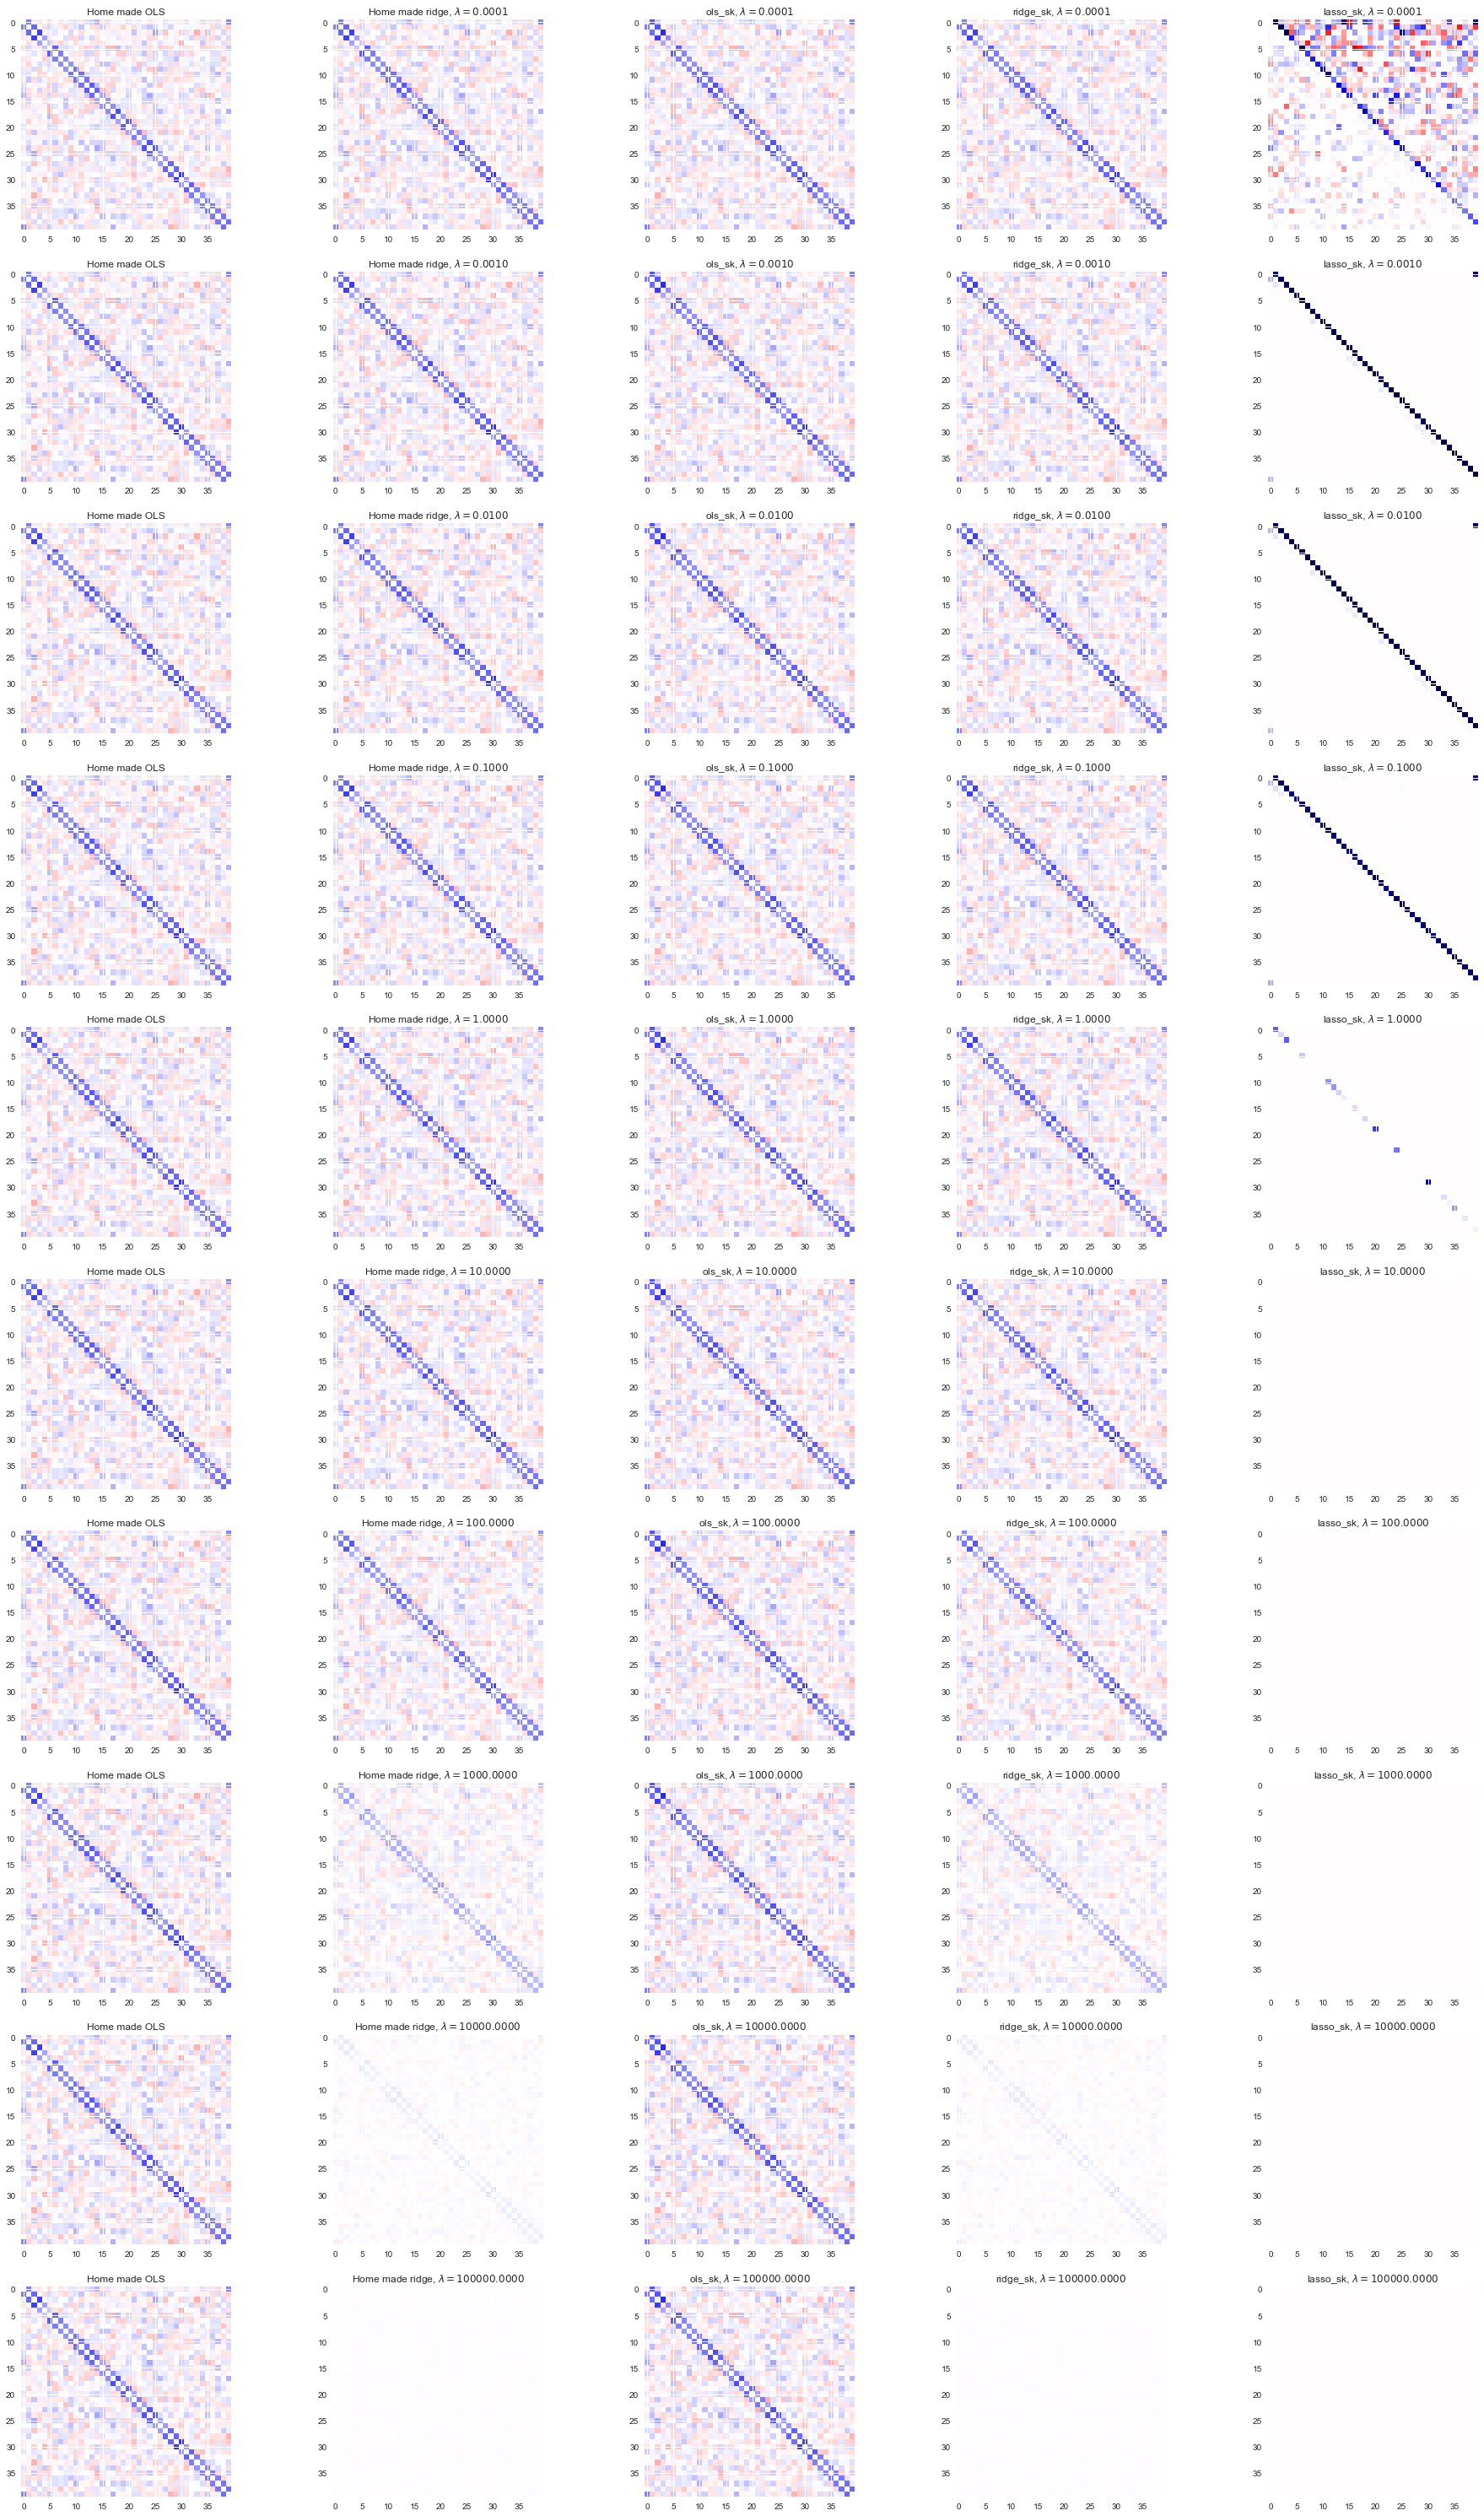

In [19]:
lambdas = np.logspace(-4, 5, 10)

train_errors = {
    "ols_own": np.zeros(lambdas.size),
    "ols_sk": np.zeros(lambdas.size),
    "ridge_own": np.zeros(lambdas.size),
    "ridge_sk": np.zeros(lambdas.size),
    "lasso_sk": np.zeros(lambdas.size)
}

test_errors = {
    "ols_own": np.zeros(lambdas.size),
    "ols_sk": np.zeros(lambdas.size),
    "ridge_own": np.zeros(lambdas.size),
    "ridge_sk": np.zeros(lambdas.size),
    "lasso_sk": np.zeros(lambdas.size)
}

plot_counter = 1

fig = plt.figure(figsize=(32, 54))

for i, _lambda in enumerate(lambdas):
    omega = get_ols_weights(X_train_own, y_train)
    y_hat_train = X_train_own @ omega
    y_hat_test = X_test_own @ omega

    train_errors["ols_own"][i] = r_squared(y_train, y_hat_train)
    test_errors["ols_own"][i] = r_squared(y_test, y_hat_test)

    plt.subplot(10, 5, plot_counter)
    plt.imshow(omega[1:].reshape(L, L), **cmap_args)
    plt.title("Home made OLS")
    plot_counter += 1

    omega = get_ridge_weights(X_train_own, y_train, _lambda)
    y_hat_train = X_train_own @ omega
    y_hat_test = X_test_own @ omega

    train_errors["ridge_own"][i] = r_squared(y_train, y_hat_train)
    test_errors["ridge_own"][i] = r_squared(y_test, y_hat_test)

    plt.subplot(10, 5, plot_counter)
    plt.imshow(omega[1:].reshape(L, L), **cmap_args)
    plt.title(r"Home made ridge, $\lambda = %.4f$" % _lambda)
    plot_counter += 1

    for key, method in zip(
        ["ols_sk", "ridge_sk", "lasso_sk"],
        [skl.LinearRegression(), skl.Ridge(alpha=_lambda), skl.Lasso(alpha=_lambda)]
    ):
        method = method.fit(X_train, y_train)

        train_errors[key][i] = method.score(X_train, y_train)
        test_errors[key][i] = method.score(X_test, y_test)

        omega = method.coef_.reshape(L, L)

        plt.subplot(10, 5, plot_counter)
        plt.imshow(omega, **cmap_args)
        plt.title(r"%s, $\lambda = %.4f$" % (key, _lambda))
        plot_counter += 1

plt.show()

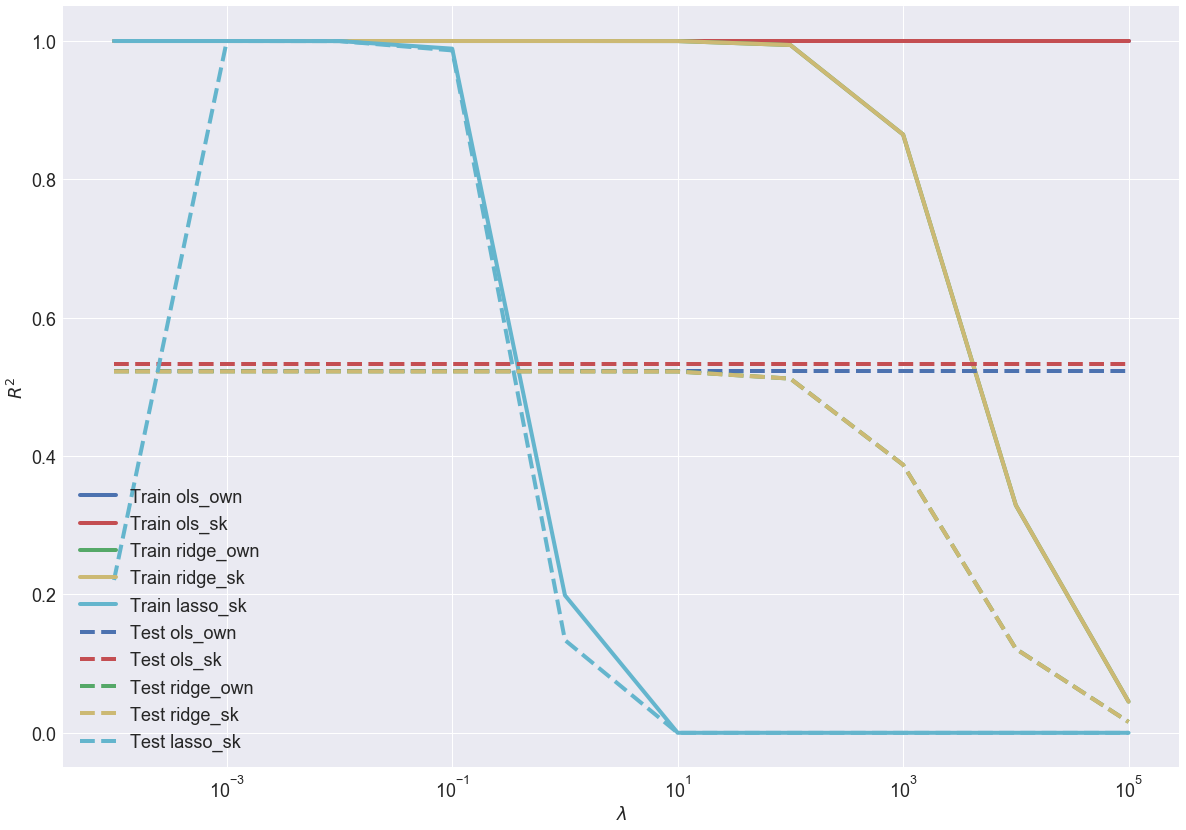

In [21]:
#R^2 plot

fig = plt.figure(figsize=(20, 14))

colors = {
    "ols_own": "b",
    "ridge_own": "g",
    "ols_sk": "r",
    "ridge_sk": "y",
    "lasso_sk": "c"
}

for key in train_errors:
    plt.semilogx(
        lambdas,
        train_errors[key],
        colors[key],
        label="Train {0}".format(key),
        linewidth=4.0
    )

for key in test_errors:
    plt.semilogx(
        lambdas,
        test_errors[key],
        colors[key] + "--",
        label="Test {0}".format(key),
        linewidth=4.0
    )
#plt.semilogx(lambdas, train_errors["ols_own"], label="Train (OLS own)")
#plt.semilogx(lambdas, test_errors["ols_own"], label="Test (OLS own)")

plt.legend(loc="best", fontsize=18)
plt.xlabel(r"$\lambda$", fontsize=18)
plt.ylabel(r"$R^2$", fontsize=18)
plt.tick_params(labelsize=18)
plt.show()

In [22]:
print(np.logspace(-4, 5, 10))
print(train_errors)
print(test_errors)
1e-1

[1.e-04 1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04 1.e+05]
{'ols_own': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), 'ols_sk': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), 'ridge_own': array([1.        , 1.        , 1.        , 0.99999999, 0.99999909,
       0.99991395, 0.99420608, 0.86478993, 0.32898911, 0.04510437]), 'ridge_sk': array([1.        , 1.        , 1.        , 0.99999999, 0.99999909,
       0.99991395, 0.99420604, 0.86478749, 0.32899924, 0.04510994]), 'lasso_sk': array([0.99999986, 0.99999889, 0.99988951, 0.98895307, 0.1987535 ,
       0.        , 0.        , 0.        , 0.        , 0.        ])}
{'ols_own': array([0.52247367, 0.52247367, 0.52247367, 0.52247367, 0.52247367,
       0.52247367, 0.52247367, 0.52247367, 0.52247367, 0.52247367]), 'ols_sk': array([0.53244826, 0.53244826, 0.53244826, 0.53244826, 0.53244826,
       0.53244826, 0.53244826, 0.53244826, 0.53244826, 0.53244826]), 'ridge_own': array([0.52247367, 0.52247367, 0.5224737 , 0.52247398, 0

0.1

/Users/joergstihler/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


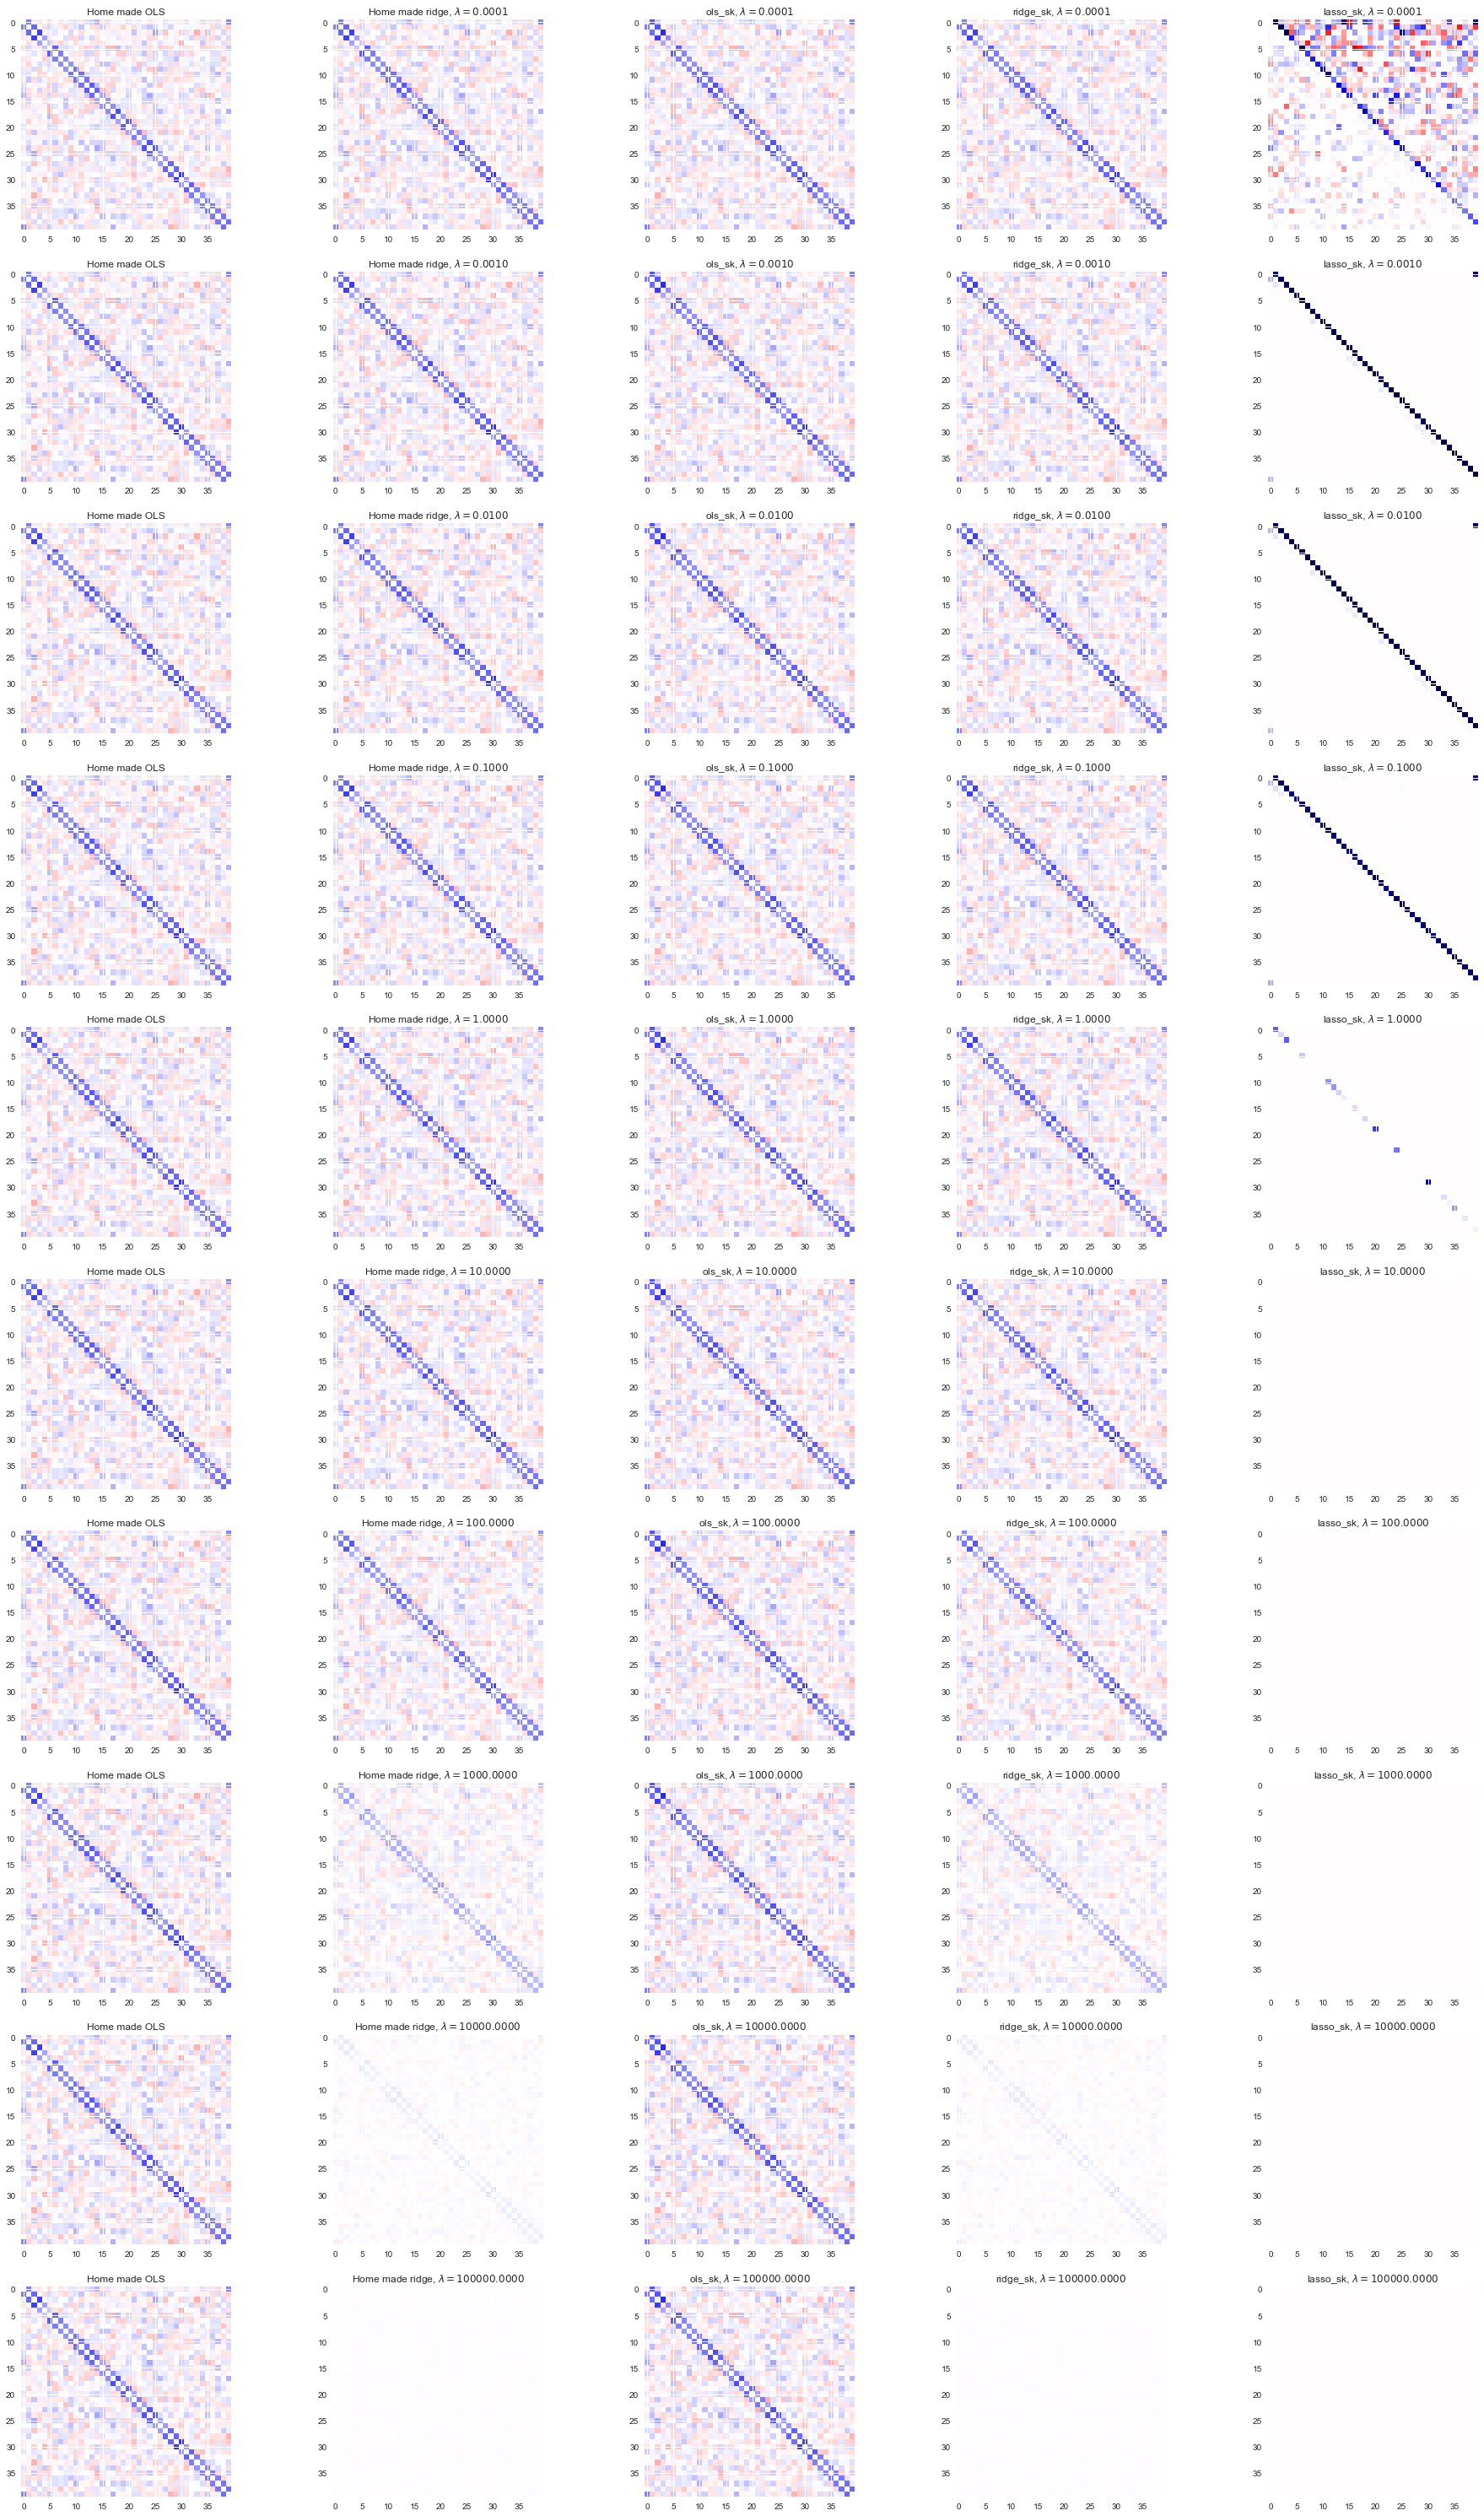

In [23]:
import sklearn
lambdas = np.logspace(-4, 5, 10)

train_errors1 = {
    "ols_own": np.zeros(lambdas.size),
    "ols_sk": np.zeros(lambdas.size),
    "ridge_own": np.zeros(lambdas.size),
    "ridge_sk": np.zeros(lambdas.size),
    "lasso_sk": np.zeros(lambdas.size)
}

test_errors1 = {
    "ols_own": np.zeros(lambdas.size),
    "ols_sk": np.zeros(lambdas.size),
    "ridge_own": np.zeros(lambdas.size),
    "ridge_sk": np.zeros(lambdas.size),
    "lasso_sk": np.zeros(lambdas.size)
}

plot_counter = 1

fig = plt.figure(figsize=(32, 54))

for i, _lambda in enumerate(lambdas):
    omega = get_ols_weights(X_train_own, y_train)
    y_hat_train = X_train_own @ omega
    y_hat_test = X_test_own @ omega

    train_errors1["ols_own"][i] = sklearn.metrics.mean_squared_error(y_train, y_hat_train)
    test_errors1["ols_own"][i] = sklearn.metrics.mean_squared_error(y_test, y_hat_test)

    plt.subplot(10, 5, plot_counter)
    plt.imshow(omega[1:].reshape(L, L), **cmap_args)
    plt.title("Home made OLS")
    plot_counter += 1

    omega = get_ridge_weights(X_train_own, y_train, _lambda)
    y_hat_train = X_train_own @ omega
    y_hat_test = X_test_own @ omega

    train_errors1["ridge_own"][i] = sklearn.metrics.mean_squared_error(y_train, y_hat_train)
    test_errors1["ridge_own"][i] = sklearn.metrics.mean_squared_error(y_test, y_hat_test)

    plt.subplot(10, 5, plot_counter)
    plt.imshow(omega[1:].reshape(L, L), **cmap_args)
    plt.title(r"Home made ridge, $\lambda = %.4f$" % _lambda)
    plot_counter += 1

    for key, method in zip(
        ["ols_sk", "ridge_sk", "lasso_sk"],
        [skl.LinearRegression(), skl.Ridge(alpha=_lambda), skl.Lasso(alpha=_lambda)]
    ):
        method = method.fit(X_train, y_train)
        y_hat1 = method.predict(X_train)
        y_hat2 = method.predict(X_test)

        train_errors1[key][i] = sklearn.metrics.mean_squared_error(y_hat1, y_train)
        test_errors1[key][i] = sklearn.metrics.mean_squared_error(y_hat2, y_test)

        omega = method.coef_.reshape(L, L)

        plt.subplot(10, 5, plot_counter)
        plt.imshow(omega, **cmap_args)
        plt.title(r"%s, $\lambda = %.4f$" % (key, _lambda))
        plot_counter += 1

plt.show()

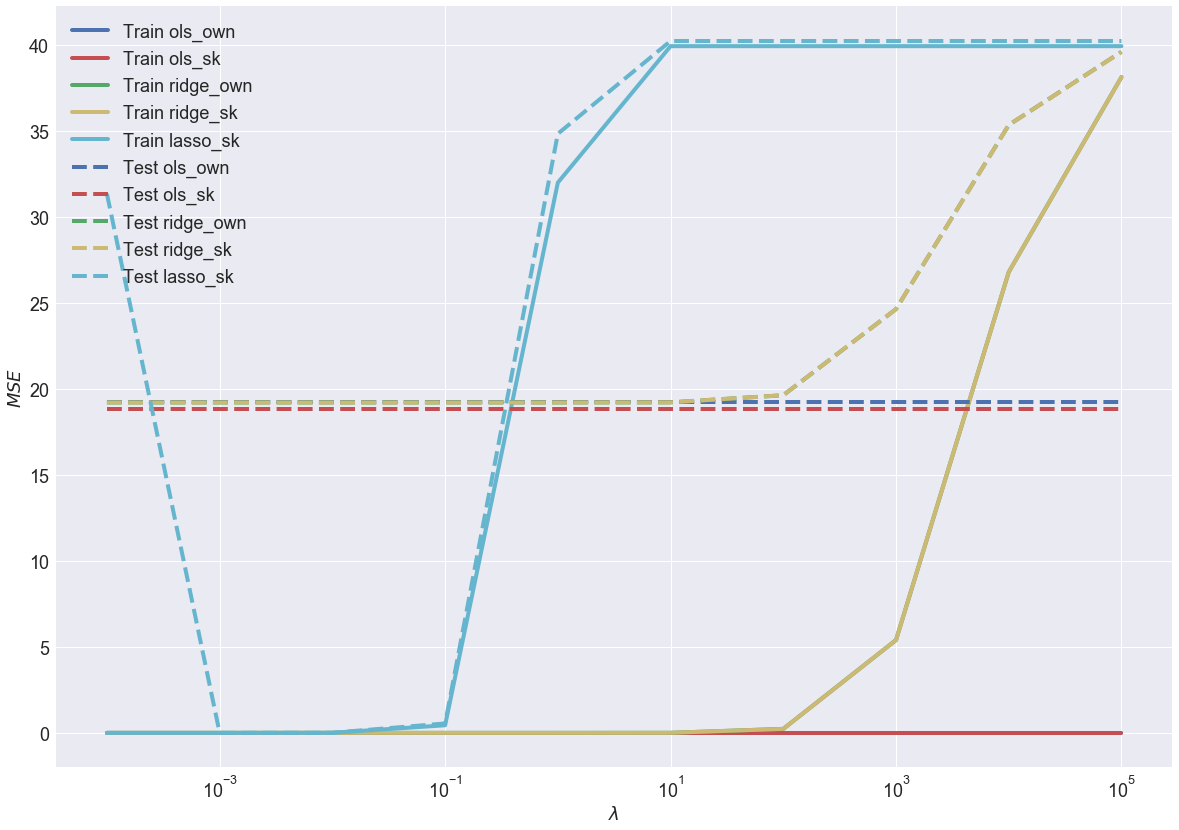

In [24]:
# MSE plot

fig = plt.figure(figsize=(20, 14))

colors = {
    "ols_own": "b",
    "ridge_own": "g",
    "ols_sk": "r",
    "ridge_sk": "y",
    "lasso_sk": "c"
}

for key in train_errors1:
    plt.semilogx(
        lambdas,
        train_errors1[key],
        colors[key],
        label="Train {0}".format(key),
        linewidth=4.0
    )

for key in test_errors1:
    plt.semilogx(
        lambdas,
        test_errors1[key],
        colors[key] + "--",
        label="Test {0}".format(key),
        linewidth=4.0
    )
#plt.semilogx(lambdas, train_errors1["ols_own"], label="Train (OLS own)")
#plt.semilogx(lambdas, test_errors1["ols_own"], label="Test (OLS own)")

plt.legend(loc="best", fontsize=18)
plt.xlabel(r"$\lambda$", fontsize=18)
plt.ylabel(r"$MSE$", fontsize=18)
plt.tick_params(labelsize=18)
plt.show()

In [25]:
train_errors1

{'ols_own': array([4.31191569e-28, 4.31191569e-28, 4.31191569e-28, 4.31191569e-28,
        4.31191569e-28, 4.31191569e-28, 4.31191569e-28, 4.31191569e-28,
        4.31191569e-28, 4.31191569e-28]),
 'ols_sk': array([6.25070012e-28, 6.25070012e-28, 6.25070012e-28, 6.25070012e-28,
        6.25070012e-28, 6.25070012e-28, 6.25070012e-28, 6.25070012e-28,
        6.25070012e-28, 6.25070012e-28]),
 'ridge_own': array([3.64741287e-13, 3.64023232e-11, 3.63990738e-09, 3.63793871e-07,
        3.61837588e-05, 3.43486041e-03, 2.31272322e-01, 5.39710091e+00,
        2.67847302e+01, 3.81185565e+01]),
 'ridge_sk': array([3.64005800e-13, 3.64003829e-11, 3.63984125e-09, 3.63787214e-07,
        3.61831072e-05, 3.43480842e-03, 2.31273943e-01, 5.39719681e+00,
        2.67839348e+01, 3.81157738e+01]),
 'lasso_sk': array([5.62177640e-06, 4.42364139e-05, 4.41019968e-03, 4.40953819e-01,
        3.19828758e+01, 3.99164000e+01, 3.99164000e+01, 3.99164000e+01,
        3.99164000e+01, 3.99164000e+01])}

In [26]:
test_errors1

{'ols_own': array([19.2055015, 19.2055015, 19.2055015, 19.2055015, 19.2055015,
        19.2055015, 19.2055015, 19.2055015, 19.2055015, 19.2055015]),
 'ols_sk': array([18.80186447, 18.80186447, 18.80186447, 18.80186447, 18.80186447,
        18.80186447, 18.80186447, 18.80186447, 18.80186447, 18.80186447]),
 'ridge_own': array([19.20550132, 19.2055013 , 19.20549999, 19.20548723, 19.20543479,
        19.21181715, 19.62666961, 24.63364745, 35.33649204, 39.59118219]),
 'ridge_sk': array([19.20565876, 19.20565862, 19.20565724, 19.20564422, 19.20558926,
        19.21194688, 19.62661042, 24.63341299, 35.33361705, 39.58286057]),
 'lasso_sk': array([3.13300489e+01, 5.51707401e-05, 5.47553665e-03, 5.47329724e-01,
        3.48244780e+01, 4.02164667e+01, 4.02164667e+01, 4.02164667e+01,
        4.02164667e+01, 4.02164667e+01])}

In [27]:
y_test

array([ 4., -0.,  4., ..., -4.,  4., -0.])

In [28]:
mse_test = sklearn.metrics.mean_squared_error(y_test, y_hat)

In [30]:
omega = get_ols_weights(X_train_own, y_train)
y_hat_train = X_train_own @ omega

In [31]:
omegam = betareg(X_train_own, y_train)
y_hat_train = X_train_own @ omegam
y_hat_test = X_test_own @ omegam
train_mse= sklearn.metrics.mean_squared_error(y_train, y_hat_train)
test_mse = sklearn.metrics.mean_squared_error(y_test, y_hat_test)
print(train_mse,'  ',test_mse)

4.311915693075295e-28    19.205501497615252


In [32]:
clf = skl.LinearRegression().fit(X_train, y_train)
J_sk = clf.coef_

y_hat_train = X_train_own @ omegam
y_hat_test = X_test_own @ omegam

In [33]:
#Crossvalidation and Bias Variance - with new data generation, same random seed

In [34]:
import numpy as np
import scipy.sparse as sp
np.random.seed(12)

import warnings
#Comment this to turn on warnings
warnings.filterwarnings('ignore')

### define Ising model aprams
# system size
L=40

# create 10000 random Ising states
states=np.random.choice([-1, 1], size=(10000,L))

def ising_energies(states,L):
    """
    This function calculates the energies of the states in the nn Ising Hamiltonian
    """
    J=np.zeros((L,L),)
    for i in range(L):
        J[i,(i+1)%L]-=1.0
    # compute energies
    E = np.einsum('...i,ij,...j->...',states,J,states)
    return E
# calculate Ising energies
energies=ising_energies(states,L)

In [35]:
X = np.zeros((n, L ** 2))
for i in range(n):
    X[i] = np.outer(spins[i], spins[i]).ravel()
y = energies
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.96)

X_train_own = np.concatenate(
    (np.ones(len(X_train))[:, np.newaxis], X_train),
    axis=1
)

X_test_own = np.concatenate(
    (np.ones(len(X_test))[:, np.newaxis], X_test),
    axis=1
)

In [37]:
def get_ols_weights(x: np.ndarray, y: np.ndarray) -> np.ndarray:
    u, s, v = scl.svd(x)
    return v.T @ scl.pinv(scl.diagsvd(s, u.shape[0], v.shape[0])) @ u.T @ y

In [ ]:
omega = get_ols_weights(X_train_own,y_train)

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
    
X_train_own = np.concatenate(
(np.ones(len(X_train))[:, np.newaxis], X_train),
axis=1
)

X_test_own_fixed = np.concatenate(
(np.ones(len(X_test))[:, np.newaxis], X_test),
axis=1
)
omegatrain = get_ols_weights(X_train_own,y_train) 
yfixedtestpred = X_test_own_fixed @ omegatrain
yfixedtestpred.shape


(1000,)

In [41]:
import random

#generating random partitions of our data 
#k-crossvalidation, we choose k =10
#note that in this code there are no mutual exclusive partitions, rather a 10 times split in random 10% test, 90% training data
k=10    

bias_var_matrix = np.zeros(1000)

mean_MSE_R2 = np.c_[(np.array(range(2,6))),np.zeros(4),np.zeros(4)]     #Matrix containing average MSE & R2 per degree
#making sure there are zeros in the matrix
for j in range(0,4):
    mean_MSE_R2[j][1]=0
    mean_MSE_R2[j][2]=0


partitionnumber = 1
for k in range(1,k+1):
    print('Partition ',partitionnumber)
    print()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
    
    X_train_own = np.concatenate(
    (np.ones(len(X_train))[:, np.newaxis], X_train),
    axis=1
    )

    X_test_own = np.concatenate(
    (np.ones(len(X_test))[:, np.newaxis], X_test),
    axis=1
    )

    
    omegatrain = get_ols_weights(X_train_own,y_train)               #regression coefficients
    zfixedtestpred = X_test_own_fixed @ omegatrain                
    bias_var_matrix=np.c_[bias_var_matrix,zfixedtestpred]
        
    print()
    partitionnumber += 1
bias_var_matrix=np.delete(bias_var_matrix, 0, 1)    
print('----------------------------------------------------------------')
print()

Partition  1


Partition  2


Partition  3


Partition  4


Partition  5


Partition  6


Partition  7


Partition  8


Partition  9


Partition  10


----------------------------------------------------------------



In [44]:
#calculation of bias-variance decomposition

from numpy import var
z_fixed_matrix=np.c_[yfixedtestpred,yfixedtestpred,yfixedtestpred,yfixedtestpred,yfixedtestpred,yfixedtestpred,yfixedtestpred,yfixedtestpred,yfixedtestpred,yfixedtestpred]
error = np.mean( np.mean((z_fixed_matrix - bias_var_matrix)**2, axis=1, keepdims=True) )
mod_variance = np.mean(np.var(bias_var_matrix,axis=1,keepdims=True))
Z=np.c_[np.mean(bias_var_matrix, axis=1, keepdims=True), yfixedtestpred]
ZZ=np.zeros(100)
for j in range(0,100):
    ZZ[j]=(Z[j][0]-Z[j][1])**2
mod_bias=np.mean(ZZ)
var_bias = mod_bias + mod_variance
print(' error    : ',error )
print(' mod_bias : ',mod_bias)
print(' mod_var  : ',mod_variance)
print(' var+bias : ',var_bias)

 error    :  6.989175145557523
 mod_bias :  3.2547384750127795
 mod_var  :  3.346926041231453
 var+bias :  6.601664516244233


In [45]:
error-var_bias

0.38751062931329017